<a href="https://colab.research.google.com/github/DeanFord7/CMM307-AdvancedArtificialIntelligence/blob/main/DeanFord1702994-CMM307Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1 - Dataset

The Twitter Sentiment Analysis (TSA) dataset contains over 70,000 records of tweets related to specific entities, whether that be a company, a game etc. Each record has four columns, an ID for the tweet, the entity the tweet is referencing, the text conatained within the tweet and the sentiment.

The aim of the task is to use the text of each tweet to predict and assign a sentiment classification of one of the following to the tweet:
<ul>
<li>Positive</li>
<li>Negative</li>
<li>Neutral</li>
<li>Irrelevant</li>
</ul>

In the dataset, 'Neutral' and 'Irrelevant' are seperate labels for the sentiment classification but both are considered to be the same result. Because of this, the 'Irrelevant' label can be removed and all records with that classification can be updated to have a label of 'Neutral' instead.

Analysing the sentiment of a given text is one of the most common uses of text classification algorithms, whether it be for binary or multi-class as this dataset is, leaving text classifications the most natural choice for the challenge posed by this dataset.

In [61]:
import kagglehub
import os

# Load dataset from kagglehub
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in directory:", files)

Path to dataset files: /root/.cache/kagglehub/datasets/jp797498e/twitter-entity-sentiment-analysis/versions/2
Files in directory: ['twitter_validation.csv', 'twitter_training.csv']


In [62]:
import pandas as pd

# Dataset is already split into a training and testing file so retrieve both
training_file_path = os.path.join(path, "twitter_training.csv")
validation_file_path = os.path.join(path, "twitter_validation.csv")

# Set column names for dataframe
column_names = ["tweet_id", "entity", "sentiment", "tweet_text"]

# Load datasets into dataframes
training_df = pd.read_csv(training_file_path, names=column_names)
validation_df = pd.read_csv(validation_file_path, names=column_names)

#print(training_df.head())
print("Train", len(training_df))
print("Val", len(validation_df))
#print(validation_df.head())

# Combine the dataframes as the pre made validation set has only 1,000 values compared to the testing sets 69,000
sentiment_df = pd.concat([training_df, validation_df], ignore_index=True)

print("Combined Dataframe:")
print(sentiment_df.head())
print("Records: ", len(sentiment_df))

# The dataset contains 6 records for each tweet with the first being the original and the next 5 being slight alterations of the text
# Remove the additional records for each tweet as the original text in the most relevant and the duplicates only have minor grammatical changes
filtered_sentiment_df = sentiment_df.drop_duplicates(subset=["tweet_id"], keep="first")

# Remove NaN values
filtered_sentiment_df = filtered_sentiment_df[filtered_sentiment_df['tweet_text'].notnull()]
# Remove empty strings
filtered_sentiment_df = filtered_sentiment_df[filtered_sentiment_df['tweet_text'].str.strip() != '']

# Change sentiment values from 'Irrelevant' to 'Neutral'
# 'Irrelevant' and 'Neutral' are treated as the same result in the dataset so convert all to 'Neutral' to avoid confusion in the results
filtered_sentiment_df.loc[filtered_sentiment_df['sentiment'] == 'Irrelevant', 'sentiment'] = 'Neutral'

print("Filtered Dataframe:")
print(filtered_sentiment_df.head())
print("Records: ", len(filtered_sentiment_df))


Train 74682
Val 1000
Combined Dataframe:
   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                          tweet_text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
Records:  75682
Filtered Dataframe:
    tweet_id       entity sentiment  \
0       2401  Borderlands  Positive   
6       2402  Borderlands  Positive   
12      2403  Borderlands   Neutral   
18      2404  Borderlands  Positive   
24      2405  Borderlands  Negative   

                                           tweet_text  
0   im getting on borderlands and i will murder yo...  
6   So I spent a 

In [63]:
tweets = list(filtered_sentiment_df['tweet_text'])
sentiments = list(filtered_sentiment_df['sentiment'])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Convert the sentiment strings into numerical values
sentiments_numerical = label_encoder.fit_transform(sentiments)



In [64]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def prep(sentences):
  prep_text = []

  words = stopwords.words('english')
  entity_labels = list(filtered_sentiment_df['entity'])
  words.extend(entity_labels)

  for sent in sentences:
    token_text = word_tokenize(sent)
    normalised_text = [token.lower() for token in token_text if token.isalpha()]

    swr_text = [token for token in normalised_text if token not in words]

    prep_text += [[lemmatizer.lemmatize(word) for word in swr_text]]
  prep_sentences = [" ".join(sentence) for sentence in prep_text]
  return prep_sentences



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Section 2 - Representation Learning

Term Frequency - Inverse Document Frequency (TF-IDF) is a method of quantifying the importance of certain strings from within a block of text. TF-IDF is broken up into two parts, Term Frequency and Inverse Document Frequency.

Term Frequency works by taking how often a word appears within the confines of the document it is found it. Inverse Document Frequency on the other hand looks at how common the word is throughout all of the documents. These two values are then multiplied together to give a TF-IDF score to represent the word, with a higher score showing a more important word.

Once a document is fed into the TF-IDF, it will be outputted as a vector matrix containing the TF-IDF representations of each word which can then be used in the machine learning algorithm.

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Set the ngram_range to 1, 2 to include both unigrams and bigrams (sets of 1 and 2 words)
tfidf_base = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Section 3 -  Algorithms

In [66]:
import tensorflow
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score

## Multi-Layer Perceptron

A Multi_Layer Perceptron (MLP) is a type of Artificial Neural Network which can be used for either classification or regression, made up of different layers of interconnected nodes. The 3 layers typically featured in an MLP are the input layer, the hidden layer(s) and the output layer.


The input layer is made up of a set of nodes which matches the size of the input vector with each each node represnting one input feature. The hidden layer is made up of a weighted linear summation and a non-linear activation function which will act on the values passed into it and transform them before passing them on to the next layer. The hidden layer can also be repeated with each layer being capable of using a different activation function. The output layer then recieves the values from the final hidden layer and transforms them into output values.

In [67]:
def mlp(dataset_size, num_classes):
  input_shape = (dataset_size,)

  model = Sequential()
  model.add(Dense(128, input_shape=input_shape, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

kf = StratifiedKFold(n_splits=5, shuffle=True)
xnp = np.array(tweets)
ynp = np.array(sentiments_numerical)

mlp_accuracy_score = []
mlp_f1_score = []

for train, test in kf.split(xnp,ynp):
  x_train, x_test, y_train, y_test = xnp[train], xnp[test], ynp[train], ynp[test]

  x_train = prep(x_train)
  x_test = prep(x_test)

  tfidf = tfidf_base
  x_train = tfidf.fit_transform(x_train)
  x_train = x_train.todense()
  x_test = tfidf.transform(x_test)
  x_test = x_test.todense()
  num_classes = len(np.unique(y_train))
  model = mlp(1000, num_classes)
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)

  # Code taken and adapted from https://keras.io/api/callbacks/early_stopping/
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2, callbacks=[early_stopping])

  test_results = model.evaluate(x_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

  mlp_accuracy_score.append(test_results[1])
  # Code taken and adapted from https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/
  mlp_predictions = model.predict(x_test)
  mlp_predictions = np.argmax(mlp_predictions, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)
  mlp_f1 = f1_score(mlp_predictions, y_test_labels, average='weighted')
  mlp_f1_score.append(mlp_f1)

print("MLP Accuracy:", np.mean(mlp_accuracy_score) * 100, "%")
print("MLP F1 Score:", np.mean(mlp_f1_score))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3925 - loss: 1.0841 - val_accuracy: 0.3961 - val_loss: 1.0619
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4799 - loss: 0.9854 - val_accuracy: 0.5728 - val_loss: 0.9088
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6589 - loss: 0.7758 - val_accuracy: 0.5657 - val_loss: 0.9144
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7140 - loss: 0.6912 - val_accuracy: 0.5642 - val_loss: 0.9318
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7292 - loss: 0.6549 - val_accuracy: 0.5418 - val_loss: 1.0069
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7479 - loss: 0.6002 - val_accuracy: 0.5229 - val_loss: 1.0607
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7877 - loss: 0.5438 - val_accuracy: 0.5097 - val_loss: 1.1408
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5827 - loss: 0.8728
Test results - Loss: 0.876408576965332

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4004 - loss: 1.0825 - val_accuracy: 0.4145 - val_loss: 1.0491
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5044 - loss: 0.9635 - val_accuracy: 0.5682 - val_loss: 0.9139
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6744 - loss: 0.7656 - val_accuracy: 0.5657 - val_loss: 0.9208
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7133 - loss: 0.6767 - val_accuracy: 0.5616 - val_loss: 0.9638
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7478 - loss: 0.6144 - val_accuracy: 0.5530 - val_loss: 1.0227
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7736 - loss: 0.5715 - val_accuracy: 0.5484 - val_loss: 1.0910
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7887 - loss: 0.5328 - val_accuracy: 0.5412 - val_loss: 1.1513
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5796 - loss: 0.8959
Test results - Loss: 0.8913763165473938 - Accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4076 - loss: 1.0837 - val_accuracy: 0.4038 - val_loss: 1.0562
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4691 - loss: 0.9894 - val_accuracy: 0.5876 - val_loss: 0.9129
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6517 - loss: 0.7834 - val_accuracy: 0.5820 - val_loss: 0.9048
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7000 - loss: 0.6974 - val_accuracy: 0.5687 - val_loss: 0.9559
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7348 - loss: 0.6367 - val_accuracy: 0.5657 - val_loss: 0.9913
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7608 - loss: 0.5911 - val_accuracy: 0.5530 - val_loss: 1.0687
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7914 - loss: 0.5352 - val_accuracy: 0.5575 - val_loss: 1.1114
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8137 - loss: 0.4894 - val_accuracy: 0.5438 - val_loss: 1.2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4057 - loss: 1.0793 - val_accuracy: 0.3921 - val_loss: 1.0482
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5150 - loss: 0.9560 - val_accuracy: 0.5784 - val_loss: 0.8897
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6727 - loss: 0.7630 - val_accuracy: 0.5662 - val_loss: 0.9073
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7100 - loss: 0.6767 - val_accuracy: 0.5631 - val_loss: 0.9783
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7318 - loss: 0.6286 - val_accuracy: 0.5535 - val_loss: 1.0240
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7597 - loss: 0.5735 - val_accuracy: 0.5499 - val_loss: 1.1087
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7879 - loss: 0.5406 - val_accuracy: 0.5377 - val_loss: 1.1950
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6000 - loss: 0.8647
Test results - Loss: 0.8632916808128357 - Accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4108 - loss: 1.0813 - val_accuracy: 0.3915 - val_loss: 1.0586
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4925 - loss: 0.9711 - val_accuracy: 0.5748 - val_loss: 0.9027
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6609 - loss: 0.7775 - val_accuracy: 0.5820 - val_loss: 0.9205
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7115 - loss: 0.6754 - val_accuracy: 0.5784 - val_loss: 0.9255
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7462 - loss: 0.6261 - val_accuracy: 0.5652 - val_loss: 0.9913
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7655 - loss: 0.5691 - val_accuracy: 0.5586 - val_loss: 1.0558
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7965 - loss: 0.5253 - val_accuracy: 0.5565 - val_loss: 1.1169
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5943 - loss: 0.8667
Test results - Loss: 0.8720755577087402 - Accuracy: 0.

## k-Nearest Neighbour

k-Nearest Neighbour (kNN) is a simple machine learning algorithm which has use in both classification and regression problems. The premise of kNN is to use the training set to find the nearest neighbour(s) to the the new value based on a chosen distance metric and use them to predict a value.

The value 'k' is used to represent the number of neighbours which the algorithm will take into account when predicting the new value. Choosing a useful 'k' value is vital in kNN, as setting it too low can leave the value sensitive to noise, while setting it too high can leave the class boundaries less distinct.

In classification, the new value is assigned a label by a majority vote from the number of neighbours in consideration, while in regression the label is assigned by taking a mean value of the labels of its nearest neighbours.

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

kf = StratifiedKFold(n_splits=5, shuffle=True)

xnp = np.array(tweets)
ynp = np.array(sentiments_numerical)

knn_accuracy_score = []
knn_f1_score = []

for train, test in kf.split(xnp,ynp):

  x_train, x_test, y_train, y_test = xnp[train], xnp[test], ynp[train], ynp[test]

  x_train = prep(x_train)
  x_test = prep(x_test)

  tfidf = tfidf_base
  x_train = tfidf.fit_transform(x_train)
  x_train = np.asarray(x_train.todense())
  x_test = tfidf.transform(x_test)
  x_test = np.asarray(x_test.todense())
  param_grid = {
        'n_neighbors': [1, 3, 5, 7]
    }

  grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
  grid_search.fit(x_train, y_train)

  best_kNN = grid_search.best_estimator_

  knn_predictions = best_kNN.predict(x_test)
  knn_acc = accuracy_score(knn_predictions, y_test)
  knn_accuracy_score.append(knn_acc)

  knn_f1 = f1_score(knn_predictions, y_test, average='weighted')
  knn_f1_score.append(knn_f1)

print("kNN Accuracy:", np.mean(knn_accuracy_score) * 100, "%")
print("kNN F1 Score:", np.mean(knn_f1_score))

kNN Accuracy: 48.765784114052956 %
kNN F1 Score: 0.524981171795172


## Naive Bayes

https://scikit-learn.org/1.5/modules/naive_bayes.html

Naive Bayes methods are supervised machine learning algorithms based on applying Bayes' theorem under the assumption that every pair of features given the class variables value has conditional independance.

While Naive Bayes is generally regarded as being a good algorithm for classification, it is also known to be bad at estimation. As well as this, the assumption of conditional independance, while overall well performing, is not always the case which can lead to incorrect classification.

In [69]:
# Code taken and adapted from https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

from sklearn import naive_bayes

nb_accuracy_scores = []
nb_f1_scores = []

Encoder = LabelEncoder()
ynp_encoded = Encoder.fit_transform(ynp)  # Encoding target labels

for train_idx, test_idx in kf.split(xnp, ynp_encoded):
    x_train, x_test = np.array(tweets)[train_idx], np.array(tweets)[test_idx]
    y_train, y_test = ynp_encoded[train_idx], ynp_encoded[test_idx]

    x_train = prep(x_train)
    x_test = prep(x_test)

    tfidf = tfidf_base
    x_train = tfidf.fit_transform(x_train)
    x_train = np.asarray(x_train.todense())
    x_test = tfidf.transform(x_test)
    x_test = np.asarray(x_test.todense())

    naive = naive_bayes.MultinomialNB()
    naive.fit(x_train, y_train)

    nb_predictions = naive.predict(x_test)

    accuracy = accuracy_score(y_test, nb_predictions)
    nb_accuracy_scores.append(accuracy)

    nb_f1 = f1_score(y_test, nb_predictions, average='weighted')
    nb_f1_scores.append(nb_f1)

print(f"Naive Bayes Accuracy:", np.mean(nb_accuracy_scores) * 100, "%")
print(f"Naive Bayes F1 Score:", np.mean(nb_f1_scores))

Naive Bayes Accuracy: 59.5112016293279 %
Naive Bayes F1 Score: 0.5922564854660175


# Section 4 - Evaluation

In terms of accuracy, both the MLP and Naive Bayes models performed relatively well, recording accuracies of around 60%. The kNN model on the other hand was far lower at around 50%, even despite it using a grid search to determine the optimal number of neighbours to consider. This is likely a result of how kNN chooses its classifications alongside the pre-processing performed. As kNN operates by choosing from the values nearest neighbours, it is possible that the pre-processing has allowed certain words to be considered which negatively influence the kNN models decision making.

[0.5869653820991516, 0.5841140747070312, 0.5955193638801575, 0.6061099767684937, 0.5934826731681824]
[0.4733197556008147, 0.4912423625254583, 0.4814663951120163, 0.49287169042769857, 0.49938900203665987]


[Text(1, 0, 'knn'), Text(2, 0, 'mlp'), Text(3, 0, 'nb')]

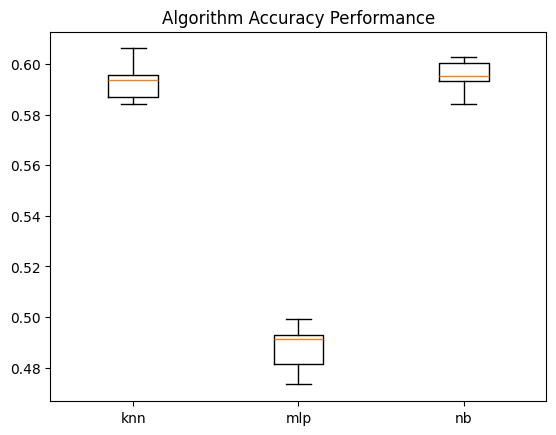

In [70]:
import matplotlib as plt

model_accuracy_comp = []
model_accuracy_comp.append(mlp_accuracy_score)
print(mlp_accuracy_score)
model_accuracy_comp.append(knn_accuracy_score)
print(knn_accuracy_score)
model_accuracy_comp.append(nb_accuracy_scores)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Accuracy Performance')
ax2.boxplot(model_accuracy_comp)
ax2.set_xticklabels(['mlp', 'knn', 'nb'])

When it comes to the F1 scores of each of the algorithms, the results are practically identical for each of the algorithms. Both the MLP and Naive Bayes models produced an F1 score of about 0.6 with kNN far behind in the 0.45-0.5 range. With the F1 scores for each model being practically identical to their accuracies, this suggests that throughout all 3 models the number of false positive and false negative predictions was practically negligible.

[Text(1, 0, 'knn'), Text(2, 0, 'mlp'), Text(3, 0, 'nb')]

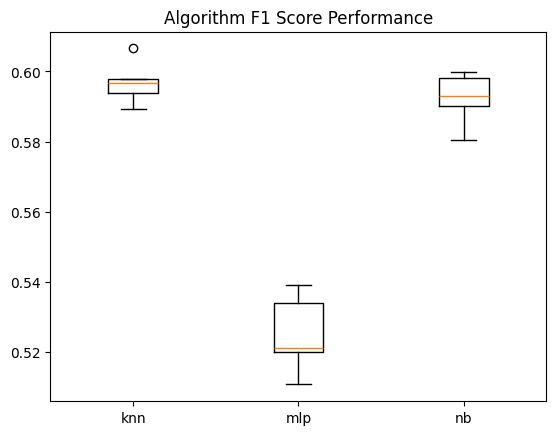

In [71]:
import matplotlib as plt

model_f1_comp = []
model_f1_comp.append(mlp_f1_score)
model_f1_comp.append(knn_f1_score)
model_f1_comp.append(nb_f1_scores)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm F1 Score Performance')
ax2.boxplot(model_f1_comp)
ax2.set_xticklabels(['mlp', 'knn', 'nb'])

# Section 5 - Paper Overview

https://www.researchgate.net/publication/352780855_Twitter_Sentiment_Analysis_using_Deep_Learning

The chosen paper aims to explore the effectiveness of different machine learning algorithms in correctly predicting the sentiment classification of a dataset of tweets. The classification is treated as a binary classification problem with the only available sentiment labels being 'Positive' and 'Negative.

The paper employs a number of pre-processing techniques specific to the problem of analysing tweets, such as replacing hashtagged words with just the text of the hashtag and shortening words where the same letter appears more than twice in sequence. <br>
The paper then trains 10 different models commonly used for text classification, with particular focus on the implementation of multiple configurations of both Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN).

Once each model had been trained, an ensemble model was created using some of the best performing models. The ensemble model took a majority vote of predictions from 5 models chosen from the most succesful configurations of the CNN and RNN models trained.

# Section 6 - Paper Algorithms

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer

In [73]:
vocab_size = 20000
random_embedding_dimension = 32
glove_embedding_dimension = 200
max_length = 40
lstm_units_random = 100
lstm_units_glove = 128
dense_units_random = 32
dense_units_glove = 64

In [74]:
# The paper only considers positive and negative sentiments for the algorithm
# Because of this we filter the dataset to only include these rows for use in the models
binary_sentiment_df = filtered_sentiment_df.drop(filtered_sentiment_df[filtered_sentiment_df['sentiment'] == 'Neutral'].index)

binary_tweets = list(binary_sentiment_df['tweet_text'])
# Pre-process the tweets
binary_tweets = prep(binary_tweets)
binary_sentiments = list(binary_sentiment_df['sentiment'])

# Convert the sentiments to numerical values
label_encoder = LabelEncoder()
binary_sentiments_numerical = label_encoder.fit_transform(binary_sentiments)

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(binary_tweets)

# Convert the tweets into sequneces and pad them to fit the max length of 40
sequences = tokenizer.texts_to_sequences(binary_tweets)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

binary_xnp = np.array(padded_sequences)
binary_ynp = np.array(binary_sentiments_numerical)

In [76]:
# Code taken and adapted from:
# https://stackoverflow.com/questions/35089956/how-to-use-the-embedding-layer-for-recurrent-neural-network-rnn-in-keras
# https://keras.io/api/layers/core_layers/embedding/
# https://keras.io/api/layers/regularization_layers/dropout/
# https://keras.io/api/layers/recurrent_layers/lstm/

# Add the layers to the random embedding model
random_embedding_model = Sequential()
random_embedding_model.add(Embedding(input_dim=vocab_size, output_dim=random_embedding_dimension, input_length=max_length))
random_embedding_model.add(Dropout(0.2))
random_embedding_model.add(LSTM(lstm_units_random))
random_embedding_model.add(Dense(dense_units_random, activation='relu'))
random_embedding_model.add(Dropout(0.2))
random_embedding_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [77]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(binary_xnp, binary_ynp, test_size=0.2, random_state=42)

random_embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Paper makes no mention of how many epochs were run
# Through testing it was found the first epoch recorded the highets accuracy with a large drop off before recovering to a value lower than the first
history = random_embedding_model.fit(x_train, y_train, epochs=8, batch_size=32, validation_split=0.2)

random_loss, random_accuracy = random_embedding_model.evaluate(x_test, y_test)
print(f"Random Embedding Model Loss: {random_loss}")
print(f"Random Embedding Model Accuracy: {random_accuracy}")

Epoch 1/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.5064 - loss: 0.6937 - val_accuracy: 0.5411 - val_loss: 0.6918
Epoch 2/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.5118 - loss: 0.6931 - val_accuracy: 0.5411 - val_loss: 0.6919
Epoch 3/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.4993 - loss: 0.6903 - val_accuracy: 0.4589 - val_loss: 0.7310
Epoch 4/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.6459 - loss: 0.6213 - val_accuracy: 0.5691 - val_loss: 0.6602
Epoch 5/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6064 - loss: 0.6315 - val_accuracy: 0.5664 - val_loss: 0.6618
Epoch 6/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6356 - loss: 0.6134 - val_accuracy: 0.5734 - val_loss: 0.6625
Epoch 7/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6389 - loss: 0.6088 - val_accuracy: 0.5743 - val_loss: 0.6617
Epoch 8/8
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6380 - loss: 0.6072 - val_accuracy

In [82]:
# Download GloVe embeddings from stanford
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d /content/glove_data

# Set the path to the GloVe file to be used
glove_file_path = '/content/glove_data/glove.6B.200d.txt'

--2024-12-04 18:00:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-12-04 18:00:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-04 18:00:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [79]:
# Code taken and adapted from https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

glove_embeddings_index = {}

# Create the GloVe matrix from the txt file
with open(glove_file_path, 'r', encoding='utf-8') as f:
  for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings_index[word] = vector

glove_matrix = np.zeros((vocab_size, glove_embedding_dimension))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            glove_matrix[index] = embedding_vector

# Add the layers to the GloVe embedding model
glove_embedding_model = Sequential()
glove_embedding_model.add(Embedding(input_dim=vocab_size, output_dim=glove_embedding_dimension, input_length=max_length, weights=[glove_matrix], trainable=True))
glove_embedding_model.add(Dropout(0.4))
glove_embedding_model.add(LSTM(lstm_units_glove))
glove_embedding_model.add(Dense(dense_units_glove, activation='relu'))
glove_embedding_model.add(Dropout(0.5))
glove_embedding_model.add(Dense(1, activation='sigmoid'))

In [80]:
x_train, x_test, y_train, y_test = train_test_split(binary_xnp, binary_ynp, test_size=0.2, random_state=42)

glove_embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Paper makes no mention of how many epochs were run
# Through testing it was found the highest accuracy came on the first epoch with a large drop off until epoch 6 which would significantly lower the average
history = glove_embedding_model.fit(x_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

glove_loss, glove_accuracy = glove_embedding_model.evaluate(x_test, y_test)
print(f"GloVe Embedding Model Loss: {glove_loss}")
print(f"GloVe Embedding Model Accuracy: {glove_accuracy}")

143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - accuracy: 0.5565 - loss: 0.6713 - val_accuracy: 0.7605 - val_loss: 0.5556
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7573 - loss: 0.5414
GloVe Embedding Model Loss: 0.5384095907211304
GloVe Embedding Model Accuracy: 0.762937068939209


# Section 7 - Paper Evaluation

The performance metric used in the paper is the accuracy of the models. In general the results of my implementation follow the same trend as the paper with the Glove Embedding Model performing better thena the Random Embedding Model. However, where the results differ is in the accuracy produced by the Random Embedding Model.

My implementation came out with an accuracy of around 60%, leaving it over 20% lower than the best implementation in the paper of 82.2%. As the layers used line up with how the model is described in the paper, I would theorize that this discrepancy is as a result of the pre-processing and feature extraction methods used in the paper, which go far more in depth with the pre-processing being tailored to the fact that the dataset contains tweets, and the feature extraction using both bigrams and unigrams and choosing the vector representation based on which one is used.

The gap between my implementation of the Glove Embedding Model and the papers is significantly smaller. My implementation produced an accuracy of around 76%, less than 10% lower than the papers model which scored 83% with its best configuration. This improvement is likely due to the use of the pre-trained word vectors provided by the glove file, with the slight gap still being present due to the more in depth pre-processing.

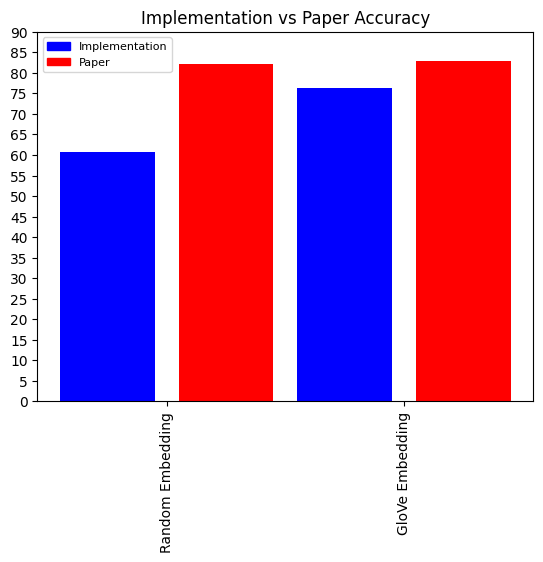

In [83]:
import matplotlib.patches as mpatches

# Best results from the paper for the Random and GloVe Embedding Models
paper_random_accuracy = 82.2
paper_glove_accuracy = 83.0

model_comp = []
model_comp.append(random_accuracy * 100)
model_comp.append(paper_random_accuracy)
model_comp.append(glove_accuracy * 100)
model_comp.append(paper_glove_accuracy)

fig, ax2 = plt.pyplot.subplots()

ax2.set_title('Implementation vs Paper Accuracy')
x_positions = range(len(model_comp))
ax2.bar(x_positions, model_comp, color=['blue', 'red', 'blue', 'red'])
ax2.set_xticks([0.5, 2.5])
ax2.set_xticklabels(['Random Embedding', 'GloVe Embedding'], rotation='vertical')

y_ticks = np.arange(0, 100, 5)
ax2.set_yticks(y_ticks)

blue_patch = mpatches.Patch(color='blue', label='Implementation')
red_patch = mpatches.Patch(color='red', label='Paper')

ax2.legend(handles=[blue_patch, red_patch], loc="best", fontsize=8, markerscale=0.8)
